## Predictive Customer Analysis 

Following the descriptive analysis of the customer purchase on `Positioning_descriptive,ipynb` notebook, here logistic regression and linear regression will be applied will be performed to deepdive into purchase analysis and forecast.

## Libraries

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression

import os 
import pickle

## Import the Data

In [7]:
def import_pickle_data(filename) :
    path = os.path.join(os.getcwd(), 'obj_data', filename)
    return pickle.load(open(path, 'rb')) #rb = read as byte datatype

In [8]:
def import_csv(filePath) :
    return pd.read_csv(filePath)

In [24]:
# loading the data file
filePath_purchase = os.path.join(os.getcwd(), 'data', 'purchase data.csv')
df_purchase = import_csv(filePath_purchase)

# importing classes
scaler = import_pickle_data('scaler.pickle')
pca = import_pickle_data('pca.pickle')
kmeans_pca = import_pickle_data('kmeans_pca.pickle')

# standardization
df_purchase.columns.values[-7:] # the 7 features standized 
features_to_include = df_purchase.columns.values[-7:]
df_purchase_std = scaler.transform(df_purchase[features_to_include])

# dimentionality reduction of the standardized data
df_purchase_pca = pca.transform(df_purchase_std)

# segmentation from the preprocessed data
segment_kmeans_pca = kmeans_pca.predict(df_purchase_pca)
df_purchase_analysis = df_purchase.copy()
df_purchase_analysis['Segment'] = segment_kmeans_pca

# binary encoding segment
segment_dummies = pd.get_dummies(df_purchase_analysis['Segment'], 
                                 prefix='Segment', prefix_sep='_')
df_purchase_analysis = pd.concat([df_purchase_analysis, segment_dummies], axis=1)

In [10]:
segment_index = {
    0 : 'Fewer Opportunity',
    1 : 'Career Focused',
    2 : 'Standard',
    3 : 'Well off'
}

In [25]:
# Differentiate the dataframe for convenience
df_pa = df_purchase_analysis.copy()

---
## Purchase probability model

Using logistic regression : 
- Target variable (Y) : Incidence (purchased - 0: no, 1: yes)
- Independent variable (X) : Price, using mean / ~~median~~ in this case

In [28]:
Y = df_pa['Incidence']

In [57]:
brand_prices = df_pa.loc[:, df_pa.columns.str.contains('Price_')]
X = pd.DataFrame({'Mean_price' : brand_prices.mean(axis=1)})

In [58]:
logit_purchase = LogisticRegression(solver='sag')

In [59]:
logit_purchase.fit(X, Y)

LogisticRegression(solver='sag')

In [64]:
logit_purchase.coef_

array([[-2.34758927]])

---
### Price elasticity of purchase probability

**Quick overview of elasticity**

Price elasticity of purchase probability : % change in purchase probability in response to a 1% change in price

- Rearranged formula :

$$ E = beta * price * (1-Pr(purchase) $$

- Interpretation : 

$$ |E| < 1 : inelastic, or : elastic $$

### Forecast price elasticity in response to price change

In [72]:
brand_prices.describe() # prices ranged bewteen 1.1 to 2.8

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [74]:
# Create a new range of price to predict PE (price elasticity)
price_range = np.arange(0.5, 3.5, 0.01)

# sklearn requires 2D array of X to predict y
df_price_range = pd.DataFrame(price_range)

In [81]:
# purchase probability matrix
purchase_pr_mat = logit_purchase.predict_proba(df_price_range)
purchase_pr = purchase_pr_mat[:,1]

In [92]:
# calculating price elatisticity for purchase probability
PE = logit_purchase.coef_[0] * price_range * (1 - purchase_pr)

In [93]:
df_price_elast = pd.DataFrame({'Price_point' : price_range, 
                               'Elasticity' : PE})

In [128]:
elastic_breakpoint = np.argmax(df_price_elast['Elasticity'] <= -1.0) # index = 75
df_price_elast.iloc[72:78,:] # below 75 : inelastic

,Price_point,Elasticity
72,1.22,-0.935128
73,1.23,-0.957760
74,1.24,-0.980755
75,1.25,-1.004112
76,1.26,-1.027833
77,1.27,-1.051917


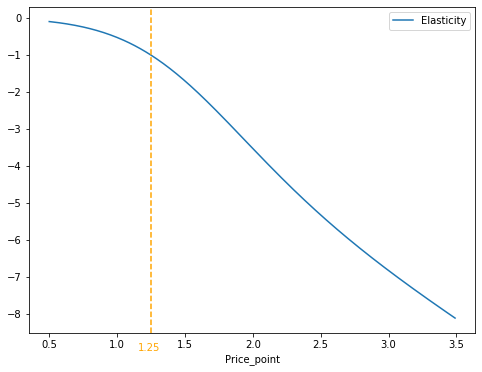

In [159]:
df_price_elast.plot(x='Price_point', y='Elasticity', figsize=(8,6))

price_breakpoint = df_price_elast.loc[elastic_breakpoint, 'Price_point']
plt.axvline(x= price_breakpoint, 
            color='orange', ls='--')
plt.text(x=price_breakpoint-0.1, y=-9, s='{0:.2f}'.format(price_breakpoint), color='orange')
plt.show()

Up to price point of 1.25, the purchase probability is inelastic in respone to price. The curve gets stepper above the price level, suggesting the increase in price will cause a greater impact (negatively) on purchase.